# Transit timing variations of Kepler-307 b and c

This example will fit Kepler-307 b and c's TTVs to derive mass and eccentricity constraints. We'll begin with some import statements.

In [1]:
import ttv2fast2furious
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## The ttv2fast2furious.kepler module

We'll use the ``ttv2fast2furious.kepler`` module, which provides a convenient interface to <a href=https://ui.adsabs.harvard.edu/#abs/2015ApJS..217...16R/abstract> Rowe et. al. (2015) </a> Kelper transit time catalog, in order to get the planets' transit times.


In [2]:
from ttv2fast2furious.kepler import KOISystemObservations

In [3]:
# Kepler-307 = KOI-1576
KOI_num = 1576
observations = KOISystemObservations(KOI_num)
observations

{'KOI-1576.01': <ttv2fast2furious.ttv2fast2furious.PlanetTransitObservations at 0x17a874980>,
 'KOI-1576.02': <ttv2fast2furious.ttv2fast2furious.PlanetTransitObservations at 0x17a881f90>,
 'KOI-1576.03': <ttv2fast2furious.ttv2fast2furious.PlanetTransitObservations at 0x17a8820d0>}

`KOISystemObservations` has returned a dictionary of `PlaneTransitObservations` objects, with on object for each KOI in the system.  Below, we'll determine the orbital periods of each KOI

In [4]:
for koi,obs in observations.items():
    T0,Period = obs.linear_best_fit()
    print(koi,Period)

KOI-1576.01 10.415738137469853
KOI-1576.02 13.084247937913403
KOI-1576.03 23.340214764299642


We'll ignore planet .03 and focus on b and c (.01 and .02), as it does not contribute or exhibit significant TTVs

In [5]:
del observations['KOI-1576.03']

## Making a `TransitTimesLinearModels` object
Now we'll construct a linear model for the planets' TTVs. 

In [6]:
linear_models = ttv2fast2furious.TransitTimesLinearModels(list(observations.values()),planet_names='bc')
print("Basis function matrix dimensions:", [bf.shape for bf in linear_models.basis_function_matrices()])
print("Transit time model basis functions: ")

for i,mdl in enumerate(linear_models.models):
    print("Planet {}:".format(linear_models.planet_names[i]))
    print(mdl.list_columns())


Basis function matrix dimensions: [(125, 5), (99, 5)]
Transit time model basis functions: 
Planet b:
['T0b', 'Pb', 'dt0_bc', 'dt1x_bc', 'dt1y_bc']
Planet c:
['T0c', 'Pc', 'dt0_cb', 'dt1x_cb', 'dt1y_cb']


The planets' transit time basis function matrices have dimension $N\times5$.  The linear model accounts for a Keplerian ephemeris, specified by an inital time of transit ('T0') and period ('P') along with TTV basis functions accounting for interactions at 0th ('dt0_ij') and first order ('dt1xy_ij') in eccentricity. The basis functions are constructed using planet periods estimated from an intial linear fit of the planets' transit ephemerides. The `TransitTimesLinearModels.update_fits()` method to re-compute basis functions based on the new best-fit periods. Its probably a good idea to do this at least once.

In [7]:
linear_models.update_fits()
print("Basis function matrix dimensions: ", [bf.shape for bf in linear_models.basis_function_matrices()])

Basis function matrix dimensions:  [(125, 5), (99, 5)]


In [8]:
linear_models.best_fits()

{'T0b': np.float64(55.213750020447314),
 'Pb': np.float64(10.415748324624337),
 'dt0_bc': np.float64(1.2018965873561152e-05),
 'dt1x_bc': np.float64(2.2858163991981726e-08),
 'dt1y_bc': np.float64(-3.1907185231502284e-09),
 'T0c': np.float64(52.548220334573344),
 'Pc': np.float64(13.084222115946263),
 'dt0_cb': np.float64(2.7899068315705535e-05),
 'dt1x_cb': np.float64(4.5983064494012607e-08),
 'dt1y_cb': np.float64(-1.9647339417857793e-08)}

In [9]:
fit_dict = linear_models.best_fits()
print("Basis func.\t value")
for key,val in fit_dict.items():
    print("{:10s}: \t {:.3g}".format(key,val))



Basis func.	 value
T0b       : 	 55.2
Pb        : 	 10.4
dt0_bc    : 	 1.2e-05
dt1x_bc   : 	 2.29e-08
dt1y_bc   : 	 -3.19e-09
T0c       : 	 52.5
Pc        : 	 13.1
dt0_cb    : 	 2.79e-05
dt1x_cb   : 	 4.6e-08
dt1y_cb   : 	 -1.96e-08


# Plot the Analytic best-fit TTV solution

Planet 2's best fit mass: 1.20 (+/- 0.36 ) x 10^-5
Planet 1's best fit mass: 2.79 (+/- 0.45 ) x 10^-5


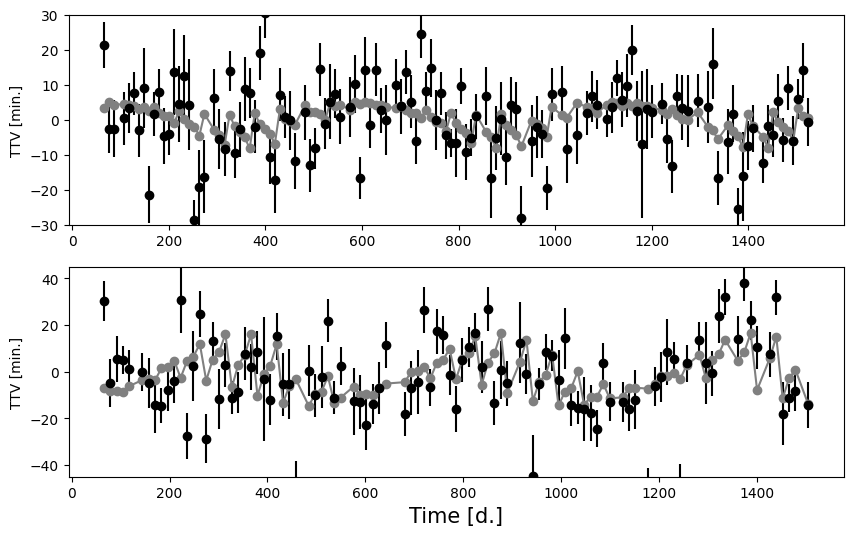

In [10]:
fig,ax = plt.subplots(2,figsize=(10,6))
day2min = 24*60

for i,mdl in enumerate(linear_models.models):
    name = linear_models.planet_names[i]
    obs = mdl.observations
    T0 = fit_dict['T0{}'.format(name)]
    X = np.array(list(mdl.best_fit().values()))
    M = mdl.basis_function_matrix
    Sigma = mdl.cov()
    
    e_mu = np.sqrt(Sigma[2,2])
    transit_times = obs.times
    unc = day2min * obs.uncertainties
    TTVobs = day2min * (obs.times - M[:,:2].dot(X[:2]))
    TTVcalc = day2min * (M[:,2:].dot(X[2:]))
        
    
    ax[i].errorbar(transit_times,TTVobs,fmt='ko',yerr=unc)
    ax[i].plot(transit_times,TTVcalc,'-o',color='gray')
    ax[i].set_ylabel('TTV [min.]')
    
    print("Planet %d's best fit mass: %.2f (+/- %.2f ) x 10^-5"%(2-i,1e5 * X[2],1e5 * e_mu))
ax[0].set_ylim(-30,30)
ax[1].set_ylim(-45,45)

ax[1].set_xlabel('Time [d.]',fontsize=15);


# Use analytic best-fit to derive joint mass-eccentricity constraints

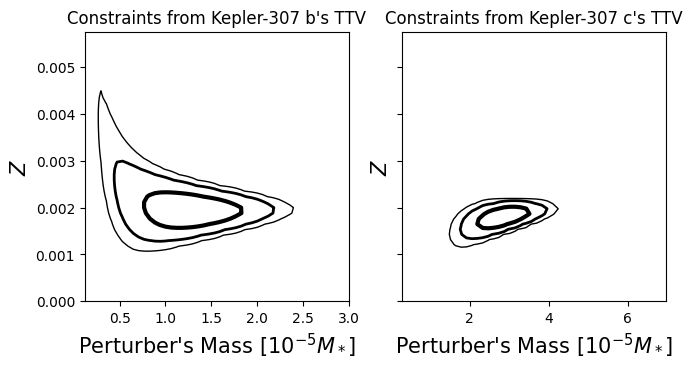

In [11]:
from scipy.integrate import quad

def chi_squared(mu,Zx,Zy,best,Sigma):
    x=np.array([mu,mu*Zx,mu*Zy])
    dx = x-best
    SigmaInv = np.linalg.inv(Sigma)
    return dx.dot(SigmaInv.dot(dx))

def transformed_likelihood(argZ,mu,absZ,best,Sigma):
    Zx = absZ * np.cos(argZ)
    Zy = absZ * np.sin(argZ)
    return mu * mu * absZ * np.exp( -0.5 * chi_squared(mu,Zx,Zy,best,Sigma) )

def integrated_likelihood(mu,absZ,best,Sigma):
    integrand = lambda x: transformed_likelihood(x,mu,absZ,best,Sigma)
    return quad(integrand,0,2*np.pi)[0]


fig,axes = plt.subplots(1,2,figsize =(15/2,7/2),sharey=True)

SCALE = 1e5
Ngrid = 50

for i,ax in enumerate(axes):
    mdl = linear_models.models[i]
    best_fit=mdl.best_fit()
    cov_matrices = linear_models.covariance_matrices()
    Sigma = cov_matrices[i][2:,2:] * SCALE * SCALE

    col_names = mdl.list_columns()
    best_vec = SCALE * np.array([best_fit[col] for col in col_names[2:]])
    mu_best = best_vec[0]
    Z_best = np.sqrt(best_vec[1:].dot(best_vec[1:]))/mu_best
    
    murange = np.linspace(0.1 * mu_best , 2.5 * mu_best,Ngrid)
    zvals = np.linspace(0,3 * Z_best,Ngrid)

    pars=[]
    for zabs in zvals:
        for mu in murange:
            pars.append((mu ,zabs ))
    def fn(x): 
        return integrated_likelihood(x[0],x[1],best_vec,Sigma)

    results = list(map(fn,pars))
    results2d = np.array(results).reshape(Ngrid,Ngrid)
    extent = [ np.min(murange), np.max(murange),min(zvals),max(zvals)]
    h=[]
    for q in [1-0.99,1-0.95,1-0.683]:
        ivmin=np.sum(np.cumsum(np.sort(results))/np.sum(results)>q)
        vmin=np.sort(results)[-ivmin]
        h.append(vmin)

    ax.contour( murange,zvals,results2d,h,colors=['black' for _ in h],linewidths=[n+1 for n in range(len(h))])

    ivmin=np.sum(np.cumsum(np.sort(results))/np.sum(results)>0.001)
    vmin=np.sort(results)[-ivmin]

    ax.set_xlabel('Perturber\'s Mass [$10^{-5}M_*$]',fontsize=15)
    ax.set_ylabel('$Z$',fontsize=15)
    ax.set_title("Constraints from Kepler-307 %s's TTV"%('bc'[i]))